Restart cuda module after suspend by:  
`$ sudo rmmod nvidia_uvm`  
`$ sudo modprobe nvidia_uvm`

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision.transforms import transforms
from torchvision import models


import atm
import atm.simclr as simclr

# DataSet

### Q: How do I let a dataset yield a pair of images?

In [2]:
import argparse 

args = argparse.Namespace()

args.data='./datasets' 
args.dataset_name='cifar10'
args.arch='resnet50'
args.workers=1
args.epochs=30 
args.batch_size=256 
args.lr=0.06 
args.wd=0.0005
args.disable_cuda=False
args.fp16_precision=True
args.out_dim=128
args.log_every_n_steps=100
args.temperature=0.07
args.n_views = 2
args.gpu_index=0
args.device='cuda' if torch.cuda.is_available() else 'cpu'


#args.bn_splits=8 
#args.cos=True 
#args.knn_k=200 
#args.knn_t=0.1 

#args.resume='' 
#args.schedule=[] 
#args.symmetric=False 

print("Using device:", args.device)

Using device: cuda


In [3]:
assert args.n_views == 2, "Only two view training is supported. Please use --n-views 2."
# check if gpu training is available
if not args.disable_cuda and torch.cuda.is_available():
    args.device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    args.device = torch.device('cpu')
    args.gpu_index = -1

# Data Loader

In [4]:
import matplotlib.pyplot as plt 

In [5]:
from PIL import Image
from typing import Any, Callable, Optional, Tuple
from torchvision.datasets import VisionDataset
from functools import partial
from astrobf.tmo import Mantiuk_Seidel

class TonemapImageDataset(VisionDataset):
    def __init__(self, 
                 data_array, 
                 tmo,
                 labels: Optional = None, 
                 train: bool=True,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None,):
        self._array = data_array
        self._good_gids = np.array([gal['img_name'] for gal in data_array])
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.tmo = tmo
        self._bad_tmo=False

    def _apply_tm(self, image):
        try:
            return self.tmo(image)
        except ZeroDivisionError:
            print("division by zero. Probably bad choice of TM parameters")
            self._bad_tmo=True
            return image

    def _to_8bit(self, image):
        """
        Normalize per image (or use global min max??)
        """

        image = (image - image.min())/image.ptp()
        image *= 255
        return image.astype('uint8')        
    
    def __len__(self) -> int:
        return len(self._array)
    
    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        """
        For super
        """
        image, _segmap, weight = self._array[idx]['data']
        image[_segmap.astype(bool)] = np.nan # Is it OK to have nan?
        image[image < 0] = 0

        image = self._to_8bit(self._apply_tm(image))
        
        label = self.img_labels[idx]
        return Image.fromarray(image), label
    
    
class TonemapImageDatasetPair(TonemapImageDataset):
    """
    returns two differently (randomly) transformed version of an image.
    
    img_labels = np.ndarray
    """
    def __getitem__(self, idx):
        image, _segmap, weight = self._array[idx]['data']
        image[_segmap.astype(bool)] = np.nan # Is it OK to have nan?
        image[image < 0] = 0
        
        image = self._to_8bit(self._apply_tm(image))
        image = Image.fromarray(image)
        label = self.img_labels[idx]
        
        if self.transform is not None:
            im_1 = self.transform(image) # random transform. 
            im_2 = self.transform(image)

        return (im_1, im_2), label
        

In [6]:
import pickle
import numpy as np

ddir = "../../tonemap/bf_data/Nair_and_Abraham_2010/"

fn = ddir + "all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

from astrobf.utils.misc import load_Nair
cat_data = load_Nair(ddir + "catalog/table2.dat")
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]

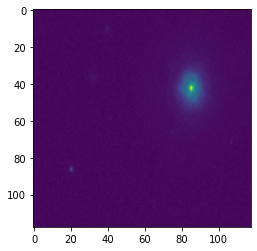

In [31]:
plt.imshow(image)

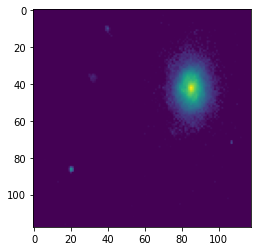

In [32]:
plt.imshow(img)

In [7]:
tmo_params = {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45}

In [8]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])])

# data prepare
train_data = TonemapImageDatasetPair(all_gals, partial(Mantiuk_Seidel, **tmo_params),
                                     labels=cat['TT'].to_numpy(),
                                     train=True, 
                                     transform=train_transform)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

#test_data = TonemapImageDataset(all_gals, train=False, transform=test_transform)
#test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)

## quick check images

In [9]:
model = simclr.models.ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

# training

In [10]:
optimizer = torch.optim.Adam(model.parameters(), args.lr, weight_decay=args.wd)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                           last_epoch=-1)

In [11]:
import importlib
importlib.reload(simclr)
importlib.reload(simclr.models)

<module 'atm.simclr.models' from '/home/hoseung/Work/ATM/atm/simclr/models.py'>

In [ ]:
np.seterr(divide='ignore')

with torch.cuda.device(args.gpu_index):
    simc = simclr.models.SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
    simc.train(train_loader) # model is saved at the end of train.

  0%|          | 0/37 [00:00<?, ?it/s]/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime
/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:268: RuntimeWarning: divide by zero encountered in log10
  lp = np.log10(lum) # L prime


# representation quality check

## linear evaluation protocol, a standard way
Train a linear classifier on the fixed representations

## Load checkpoint

In [19]:
checkpoint = torch.load('./runs/Aug09_01-49-10_hoseung/checkpoint_0030.pth.tar', map_location=args.device)
state_dict = checkpoint['state_dict']

In [118]:
#sclr = simclr.models.SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, args=args)
#resnet = sclr.model
resnet = simclr.models.ResNetSimCLR(base_model=args.arch, out_dim=args.out_dim)

log = resnet.load_state_dict(state_dict, strict=False)
print(log)

<All keys matched successfully>


### Discard the projection head and leave the original backbone. 

In [30]:
# drop the projectio head
resnet.backbone.fc = nn.Identity()

In [119]:
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(args.device)

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [109]:
from torch.utils.data import DataLoader
def get_cifar10_data_loaders(download, shuffle=False, batch_size=256):
    train_dataset = torchvision.datasets.CIFAR10('./data', train=True, download=download,
                                  transform=transforms.ToTensor())

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            num_workers=0, drop_last=False, shuffle=shuffle)

    test_dataset = torchvision.datasets.CIFAR10('./data', train=False, download=download,
                                  transform=transforms.ToTensor())

    test_loader = DataLoader(test_dataset, batch_size=2*batch_size,
                            num_workers=10, drop_last=False, shuffle=shuffle)
    return train_loader, test_loader

train_loader, test_loader = get_cifar10_data_loaders(download=True)
# num_workers=0. Using multiple (even num_workers=1) causes an error 'can only test a child process'.

Files already downloaded and verified
Files already downloaded and verified


In [120]:
epochs = 100
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch,y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)
        
        logits = resnet(x_batch)
        loss = criterion(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
        top1_train_accuracy += top1[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    top1_train_accuracy /= (counter + 1)
    top1_accuracy = 0
    top5_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(args.device)
        y_batch = y_batch.to(args.device)

        logits = resnet(x_batch)

        top1, top5 = accuracy(logits, y_batch, topk=(1,5))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]

    top1_accuracy /= (counter + 1)
    top5_accuracy /= (counter + 1)
    print(f"Epoch {epoch}\tTop1 Train accuracy {top1_train_accuracy.item()}\tTop1 Test accuracy: {top1_accuracy.item()}\tTop5 test acc: {top5_accuracy.item()}")

KeyboardInterrupt: 

In [ ]:
class SimCLRClassifier(nn.Module):
    def __init__(self, base_model, freeze_base, base_feature_size=512, n_views=2):
        self.embeddings = base_model
        
        if freeze_base:
            print("Freezing embeddings")
            for param in self.embeddings.parameters():
                param.requires_grad = False
                
        self.classifier = nn.Linear(in_features = base_feature_size, 
                                   out_features = n_views) #
    
    def forward(self, X, *args):
        emb = self.embeddings(X)
        return self.classifier(emb)
    
class SimCLRClassifierModule

In [63]:
from sklearn.metrics import classification_report

In [ ]:
def evaluate(data_loader, module):
    with torch.no_grad():
        progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
        module.eval().cuda()
        true_y, pred_y = [], []
        for i, batch_ in enumerate(data_loader):
            X, y = batch_
            print(progress[i % len(progress)], end="\r")
            y_pred = torch.argmax(module(X.cuda()), dim=1)
            true_y.extend(y.cpu())
            pred_y.extend(y_pred.cpu())
        print(classification_report(true_y, pred_y, digits=3))
        return true_y, pred_y

_ = evaluate(module.val_dataloader(), module)